In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from geo_transform.tf_tps import ThinPlateSpline as tps

import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial
import os

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from dev_utils import tf_session
tf_session.setup_gpus(True, 0.95)

ValueError: Cannot set memory growth on device when virtual devices configured

# 1.Data load

In [8]:
!ls data_loader

 __pycache__	 models.py	  train_CNNgeo.py
 checkpoints	 original.png	 "train_cnngeo-kim's_loss.ipynb"
 configs	 overfit.json	  train_cnngeo-mini-imagenet.ipynb
 data_loader	 sample_dataset   train_cnngeo.ipynb
 geo_transform	 tps_test.ipynb   utils
 models		 train.py


In [13]:
import json
from data_loader import load
with open("overfit.json") as file:
        config = json.load(file)


batch_size = config['train']['batch_size']
splits = ['train']
datasets = load(splits, config)
ds = datasets['train'].batch(
        batch_size).prefetch(tf.data.experimental.AUTOTUNE)

ModuleNotFoundError: No module named 'data_loader.dev'

In [5]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 64, 64, 3) (10, 64, 64, 3)
(10, 9, 2)


In [6]:
input_size = (64, 64)
output_size = (64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


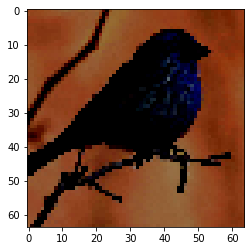

In [7]:
plt.imshow(A[0]/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


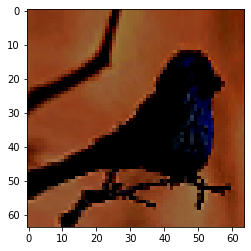

In [8]:
plt.imshow(B[0]/255)

# 2. Model definition

In [9]:
# (a) feature extraction
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block3_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)

In [10]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [11]:
# (b) channel-wise l2 normalization
def feature_l2_normalization(feature_map):
    #input(feature map) has tensor-shape (N, H, W, D)
    l2_norm = tf.math.sqrt(tf.reduce_sum(tf.pow(feature_map, 2), axis=-1))  # (N, H, W)
    l2_norm = tf.expand_dims(l2_norm, axis=-1)  # (N, H, W, 1)
    # (N, H, W, D) tensor divided by (N, H, W, 1) tensor
    return feature_map / (l2_norm+1E-5)

In [12]:
# (c) Matching layer
class Correlation_network(tf.keras.layers.Layer):
    def __init__(self):
        super(Correlation_network, self).__init__()

    def call(self, feature_A, feature_B):
        # featureA : feature information from source image
        # featureB : feature information from target image
        #assert feature_A.shape == feature_B.shape
        # new feature A and feature B have new shape of tensors.
        # featureA has tensor shape as [batch, HA, WA, 1, 1, depth]
        # featureB has tensor shape as [batch, 1, 1, HB, WB, depth]
        feature_A = feature_A[:, :, :, tf.newaxis, tf.newaxis, :]
        feature_B = feature_B[:, tf.newaxis, tf.newaxis, :, :, :]
        # correlation score has tensor shape as [batch, HA, WA, HB, WB]
        corr_score = tf.reduce_sum(tf.multiply(feature_A, feature_B), axis=-1)
        return corr_score
# repeat penalty
def normalize_correlation(corr_score):
    ambiguous_match_penalty = tf.math.sqrt(tf.reduce_sum(tf.pow(corr_score, 2), axis=[3, 4], keepdims=True))
    corr_score = tf.math.divide(corr_score, ambiguous_match_penalty+0.00001)
    # see eq (2) in "End-to-end weakly-supervised semantic alignment"
    return corr_score

In [13]:
feature_A = feature_extractor(A)
feature_B = feature_extractor(B)
print(feature_A.shape, feature_B.shape)

(10, 16, 16, 256) (10, 16, 16, 256)


In [14]:
normalized_feature_A = feature_l2_normalization(feature_A)
normalized_feature_B = feature_l2_normalization(feature_B)
print(normalized_feature_A.shape, normalized_feature_B.shape)

(10, 16, 16, 256) (10, 16, 16, 256)


In [15]:
correlation_net = Correlation_network()
correlations = correlation_net(normalized_feature_A, normalized_feature_B)
print(correlations.shape)

(10, 16, 16, 16, 16)


In [16]:
correlations = tf.keras.layers.Activation("relu")(correlations)
correlations = normalize_correlation(correlations)

In [17]:
# (d) regressor
class Spatial_regressor(tf.keras.layers.Layer):
    def __init__(self, num_param):
        super(Spatial_regressor, self).__init__()
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, (7, 7)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (5, 5)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_param),
        ])
    def call(self, x):
        AH,AW,BHW = x.shape[1], x.shape[2], x.shape[3]*x.shape[4]
        x = tf.reshape(x, [-1, AH, AW, BHW])
        x = self.regressor(x)
        x = tf.reshape(x, [-1, 9, 2])
        return x

In [18]:
spatial_regressor = Spatial_regressor(9*2)
geo_parameters = spatial_regressor(correlations)
print(geo_parameters.shape)

(10, 9, 2)


In [19]:
class CNN_geotransform(tf.keras.Model):
    def __init__(self, feature_extractor, num_param):
        super(CNN_geotransform, self).__init__()
        self.feature_extractor = feature_extractor
        self.correlation_net = Correlation_network()
        self.regressor = Spatial_regressor(9*2)
    def call(self, imageA, imageB):
        featureA = self.feature_extractor(imageA)
        featureB = self.feature_extractor(imageB)
        featureA = feature_l2_normalization(featureA)
        featureB = feature_l2_normalization(featureB)
        correlations = self.correlation_net(featureA, featureB)
        correlations = tf.keras.layers.Activation("relu")(correlations)
        correlations = normalize_correlation(correlations)
        geo_parameters = self.regressor(correlations)
        return geo_parameters

In [20]:
cnngeo = CNN_geotransform(feature_extractor, 9*2)

In [21]:
geo_paramters = cnngeo(A, B)

In [22]:
cnngeo.summary()

Model: "cnn_geotransform"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 16, 16, 256)       1735488   
_________________________________________________________________
correlation_network_1 (Corre multiple                  0         
_________________________________________________________________
spatial_regressor_1 (Spatial multiple                  1852882   
Total params: 3,588,370
Trainable params: 3,587,986
Non-trainable params: 384
_________________________________________________________________


In [23]:
geo_paramters.shape

TensorShape([10, 9, 2])

# 3.Training

In [24]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block3_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)
cnngeo = CNN_geotransform(feature_extractor, 9*2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

In [25]:

def loss_fn(preds, labels):
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
    num_batch = preds.shape[0]
    pred_grid_x, pred_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), preds, (20, 20))
    gt_grid_x, gt_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), labels, (20, 20))
    
    dist = tf.sqrt(tf.pow(pred_grid_x - gt_grid_x, 2) + tf.pow(pred_grid_y - gt_grid_y, 2))
    loss_mean = tf.reduce_mean(dist)
    return loss_mean

'''
def loss_fn(preds, labels):
    loss_mean = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.pow(preds - labels, 2), axis = -1)))
    return loss_mean
'''
@tf.function
def train_step(image_A, image_B, labels, model, optimizer):
    with tf.GradientTape() as tape:
        preds = model(image_A, image_B)
        loss = loss_fn(preds, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [32]:
train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(200):
    for step, (image_a, image_b, labels) in enumerate(ds):
        t_loss = train_step(image_a, image_b, labels, cnngeo, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

Epoch 1, Loss: 0.983299195766449
Epoch 2, Loss: 0.8160690069198608
Epoch 3, Loss: 0.8965544700622559
Epoch 4, Loss: 0.8969438076019287
Epoch 5, Loss: 0.8366936445236206
Epoch 6, Loss: 0.8712580800056458
Epoch 7, Loss: 0.899555504322052
Epoch 8, Loss: 0.902816891670227
Epoch 9, Loss: 0.8315864205360413
Epoch 10, Loss: 0.7611414790153503
Epoch 11, Loss: 0.8794077038764954
Epoch 12, Loss: 0.8660516738891602
Epoch 13, Loss: 0.8741300106048584
Epoch 14, Loss: 0.8007309436798096
Epoch 15, Loss: 0.8879759311676025
Epoch 16, Loss: 0.8305503726005554
Epoch 17, Loss: 0.8673090934753418
Epoch 18, Loss: 0.8864530324935913
Epoch 19, Loss: 0.8387172818183899
Epoch 20, Loss: 0.8762103915214539
Epoch 21, Loss: 0.7467928528785706
Epoch 22, Loss: 0.8721474409103394
Epoch 23, Loss: 0.8800209760665894
Epoch 24, Loss: 0.8099024295806885
Epoch 25, Loss: 0.8599321246147156
Epoch 26, Loss: 0.8591042757034302
Epoch 27, Loss: 0.8750954866409302
Epoch 28, Loss: 0.8723393678665161
Epoch 29, Loss: 0.84676307439804

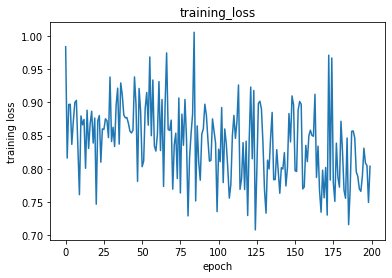

In [33]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [34]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

(10, 64, 64, 3) (10, 64, 64, 3)


In [35]:
def restore_original_image_from_array(x, data_format=None):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


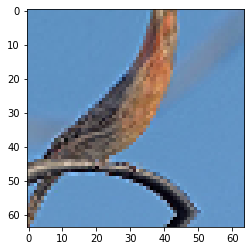

In [42]:
plt.imshow(restore_original_image_from_array(B[4].numpy())/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


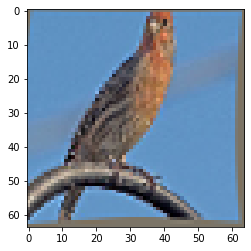

In [43]:
plt.imshow(restore_original_image_from_array(warping_images[4])/255)